## Problem Overview
- Predict which Housing Projects would win the next round of California's tax-exempt bond allocations via CDLAC (AWARD = yes)
- Not sure how this prediction will be used in the big picture
- Supervised + classification + batch training problem
- Metric to use: Accuracy and precision? (Confusion matrix)
- Assumptions:
  - The next round of predictions will have the same categories, similar level of competition and funding available
- Challenges:
  - Is 90 instances enough to get a good model? Use a simple model
  - Small dataset -> risk of overfitting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# ensure changes in files are reflected
%load_ext autoreload
%autoreload 2
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
df = pd.read_csv("../data/processed/merged_dataset.csv")

In [3]:
df.head()

,APPLICATION NUMBER,"NC POOL SELECTION: HOMELESS, ELI/VLI, MIP",AWARD,PROJECT NAME,CONSTRUCTION TYPE,HOUSING TYPE,CITY,COUNTY,TOTAL UNITS,LOW INCOME UNITS,MARKET RATE UNITS,UNITS FOR HOMELESS,HOMELESS %,AVERAGE TARGETED AFFORDABILITY,TOTAL PROJECT COSTS,BOND REQUEST,ANNUAL FEDERAL CREDIT REQUEST,STATE CREDIT REQUEST,CDLAC POOL,NEW CONSTRUCTION SET ASIDE,BIPOC PRE-QUALIFIED,CTCAC REGION,CDLAC REGION,CDLAC TOTAL POINTS SCORE,PRESERVATION AND OTHER REHAB. PROJECT PRIORITIES (20 PTS),NEW CONSTRUCTION DENSITY & LOCAL INCENTIVES (10 PTS),EXCEEDING MINIMUM INCOME RESTRICTIONS (20 PTS),EXCEEDING MINIMUM RENT RESTRICTIONS (10 PTS),GP & MGMT. CO. EXPERIENCE (10 PTS),HOUSING NEEDS (10 PTS),LEVERAGED SOFT RESOURCES (8 PTS),READINESS TO PROCEED (10 PTS),AFFIRMATIVELY FURTHERING FAIR HOUSING (10 PTS),SERVICE AMENITIES (10 PTS),COST CONTAINMENT (12 PTS),SITE AMENITIES (10 PTS),CDLAC TIE-BREAKER SELF SCORE,CDLAC APPLICANT,CTCAC APPLICANT,GP1 COMPANY,GP1 CONTACT,GP1 PARENT ORGANIZATION,GP2 COMPANY,GP2 CONTACT,GP2 PARENT COMPANY,GP3 COMPANY,GP3 CONTACT,GP3 PARENT COMPANY
0,CA-25-404,none,Yes,TBV Villas at Renaissance,New Construction,Large Family,Richmond,Contra Costa,105,104,0,0,0.0,0.520192,7.974608e+07,39172547.0,3453606,0,New Construction,none,Yes,East Bay Region: Alameda and Contra Costa Coun...,"Bay Area (Alameda, Contra Costa, Marin, San Fr...",120,0,10,20,10,10,10,8,10,10,10,12,10,1.270722,California Municipal Finance Authority,"GUIDING LIGHT INC-SANDIDGE URBAN GROUP, INC Jo...",Sandidge Urban Group,Cherene Sandidge,none,Guiding Light Inc.,Thomas Vaughns,none,none,none,none
1,CA-25-405,none,No,Adda and Paul Safran Senior Housing,Acq and Rehabilitation,Non-Targeted,Venice,Los Angeles,64,63,0,0,0.0,0.492063,4.326484e+07,21300000.0,1624431,0,Preservation,none,No,City of Los Angeles,City of Los Angeles,104,14,0,20,10,10,0,8,10,0,10,12,10,1.258159,City of Los Angeles,APS Venice LP,"Mountain Park Terrace, Inc.",Mary Grace Crisostomo,HumanGood Affordable Housing,none,none,none,none,none,none
2,CA-25-406,none,Yes,10953 Whipple,New Construction,Non-Targeted,Los Angeles,Los Angeles,91,90,0,0,0.0,0.600000,2.704032e+07,13850000.0,1126137,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.562613,California Municipal Finance Authority,"HVN Development, LLC",HVN 10953 Whipple LLC,Tommy Beadel,"HVN Development, LLC","Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none
3,CA-25-407,none,Yes,5403 Inglewood,New Construction,Non-Targeted,Los Angeles,Los Angeles,46,45,0,0,0.0,0.600000,1.448602e+07,7325000.0,598975,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.309339,California Municipal Finance Authority,"HVN Development, LLC",HVN 5403 Inglewood LLC,Tommy Beadel,"HVN Development, LLC","Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none
4,CA-25-408,none,No,12432 Moorpark,New Construction,Non-Targeted,Los Angeles,Los Angeles,102,101,0,0,0.0,0.600000,3.478839e+07,17975000.0,1412345,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.655012,California Municipal Finance Authority,HVN Development LLC,HVN 12432 Moorpark LLC,Tommy Beadel,HVN Development LLC,"Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none


## Preprocessing for training
- Define X_values and y_values
  - 12 columns selected (5 categorical, 7 numeric) to be used as features
  - "AWARD" is used as the label 
- Split into training and testing (75/25)
  - stratified spliting due to class imbalance and small dataset (40% "Yes" compared to 60% "No")
- Find Correlations
- Data Cleaning and transform
  - cleaning already done in previous steps
  - OneHotEncoding (convert categorical to numeric)
  - Feature Scaling (normalisation, standardisation or log scaling)
  - Binning (numeric to categorical)
  - Clipping? (probably not needed since no extreme outliers)


### Define X and y

In [4]:
y_values = df["AWARD"].map({'Yes': 1, 'No': 0})
y_values.head()

0    1
1    0
2    1
3    1
4    0
Name: AWARD, dtype: int64

In [5]:
numeric = ["AVERAGE TARGETED AFFORDABILITY", 'CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE', "TOTAL PROJECT COSTS", "BOND REQUEST", "ANNUAL FEDERAL CREDIT REQUEST", "HOMELESS %"]
cat = ["CONSTRUCTION TYPE", "HOUSING TYPE", "CDLAC POOL", "NEW CONSTRUCTION SET ASIDE", "CDLAC REGION"]
X_values = df[numeric + cat]

In [6]:
X_values.head()

,AVERAGE TARGETED AFFORDABILITY,CDLAC TOTAL POINTS SCORE,CDLAC TIE-BREAKER SELF SCORE,TOTAL PROJECT COSTS,BOND REQUEST,ANNUAL FEDERAL CREDIT REQUEST,HOMELESS %,CONSTRUCTION TYPE,HOUSING TYPE,CDLAC POOL,NEW CONSTRUCTION SET ASIDE,CDLAC REGION
0,0.520192,120,1.270722,7.974608e+07,39172547.0,3453606,0.0,New Construction,Large Family,New Construction,none,"Bay Area (Alameda, Contra Costa, Marin, San Fr..."
1,0.492063,104,1.258159,4.326484e+07,21300000.0,1624431,0.0,Acq and Rehabilitation,Non-Targeted,Preservation,none,City of Los Angeles
2,0.600000,119,1.562613,2.704032e+07,13850000.0,1126137,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles
3,0.600000,119,1.309339,1.448602e+07,7325000.0,598975,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles
4,0.600000,119,1.655012,3.478839e+07,17975000.0,1412345,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles


In [7]:
X_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AVERAGE TARGETED AFFORDABILITY  91 non-null     float64
 1   CDLAC TOTAL POINTS SCORE        91 non-null     int64  
 2   CDLAC TIE-BREAKER SELF SCORE    91 non-null     float64
 3   TOTAL PROJECT COSTS             91 non-null     float64
 4   BOND REQUEST                    91 non-null     float64
 5   ANNUAL FEDERAL CREDIT REQUEST   91 non-null     int64  
 6   HOMELESS %                      91 non-null     float64
 7   CONSTRUCTION TYPE               91 non-null     object 
 8   HOUSING TYPE                    91 non-null     object 
 9   CDLAC POOL                      91 non-null     object 
 10  NEW CONSTRUCTION SET ASIDE      91 non-null     object 
 11  CDLAC REGION                    91 non-null     object 
dtypes: float64(5), int64(2), object(5)
mem

In [8]:
X_values.shape

(91, 12)

### Split into train and test

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size = 0.25, stratify=y_values, random_state=42)

In [10]:
X_train.shape

(68, 12)

In [11]:
y_train.value_counts()/len(y_train)

AWARD
0    0.588235
1    0.411765
Name: count, dtype: float64

In [12]:
y_values.value_counts()/len(y_values)

AWARD
0    0.582418
1    0.417582
Name: count, dtype: float64

### Finding Correlations
- strong correlation between total project costs, bond request and annual federal credit request (>0.9)
  - perhaps try removing two of these highly correlated features that don't provide any insight to the ML model
- moderate negative correlation between homeless % and average targeted affordability (-0.47), self score and total points scored (-0.41)
- Slight correlation between total points and homeless % (0.24)/credit req (0.31)/bond req (0.27)/project cost(0.27)
  - again, you see the similarity in credit req, bond req and proj cost 

<Axes: >

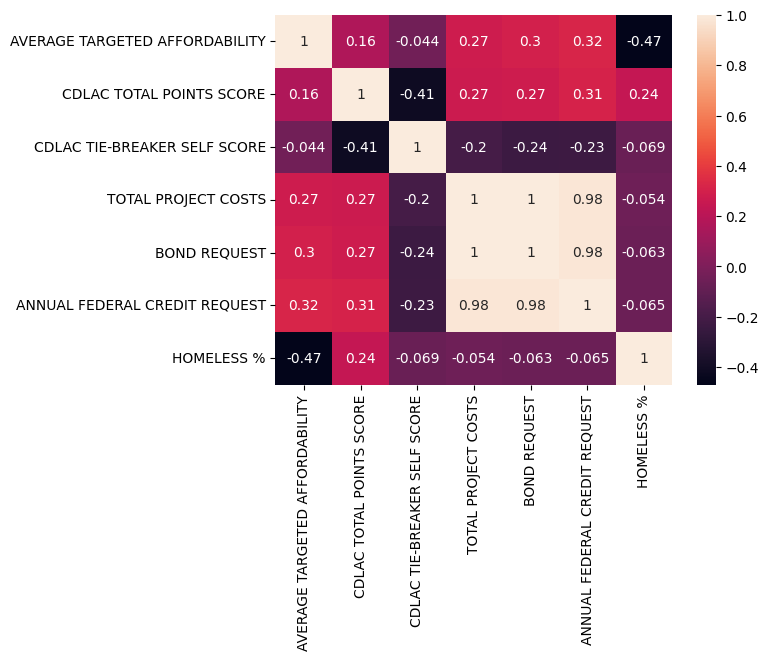

In [13]:
sb.heatmap(X_train[numeric].corr(), annot=True)

array([[<Axes: xlabel='TOTAL PROJECT COSTS', ylabel='TOTAL PROJECT COSTS'>,
        <Axes: xlabel='BOND REQUEST', ylabel='TOTAL PROJECT COSTS'>,
        <Axes: xlabel='ANNUAL FEDERAL CREDIT REQUEST', ylabel='TOTAL PROJECT COSTS'>],
       [<Axes: xlabel='TOTAL PROJECT COSTS', ylabel='BOND REQUEST'>,
        <Axes: xlabel='BOND REQUEST', ylabel='BOND REQUEST'>,
        <Axes: xlabel='ANNUAL FEDERAL CREDIT REQUEST', ylabel='BOND REQUEST'>],
       [<Axes: xlabel='TOTAL PROJECT COSTS', ylabel='ANNUAL FEDERAL CREDIT REQUEST'>,
        <Axes: xlabel='BOND REQUEST', ylabel='ANNUAL FEDERAL CREDIT REQUEST'>,
        <Axes: xlabel='ANNUAL FEDERAL CREDIT REQUEST', ylabel='ANNUAL FEDERAL CREDIT REQUEST'>]],
      dtype=object)

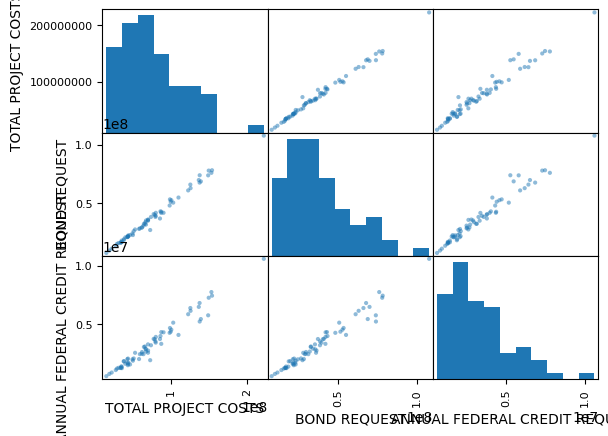

In [14]:
x_plot1 = X_train[["TOTAL PROJECT COSTS", "BOND REQUEST", "ANNUAL FEDERAL CREDIT REQUEST"]]
pd.plotting.scatter_matrix(x_plot1)

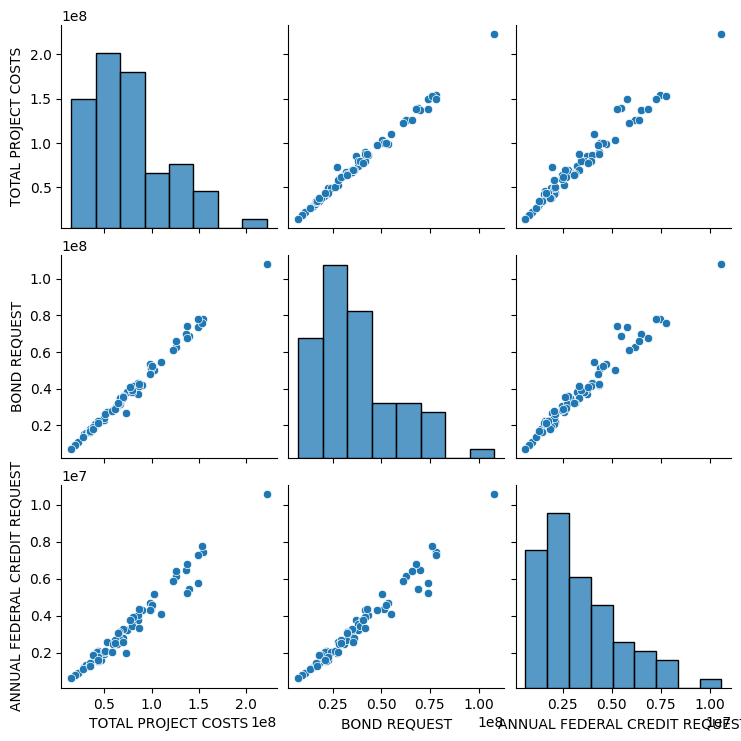

In [15]:
sb.pairplot(x_plot1)

array([[<Axes: xlabel='HOMELESS %', ylabel='HOMELESS %'>,
        <Axes: xlabel='AVERAGE TARGETED AFFORDABILITY', ylabel='HOMELESS %'>],
       [<Axes: xlabel='HOMELESS %', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='AVERAGE TARGETED AFFORDABILITY', ylabel='AVERAGE TARGETED AFFORDABILITY'>]],
      dtype=object)

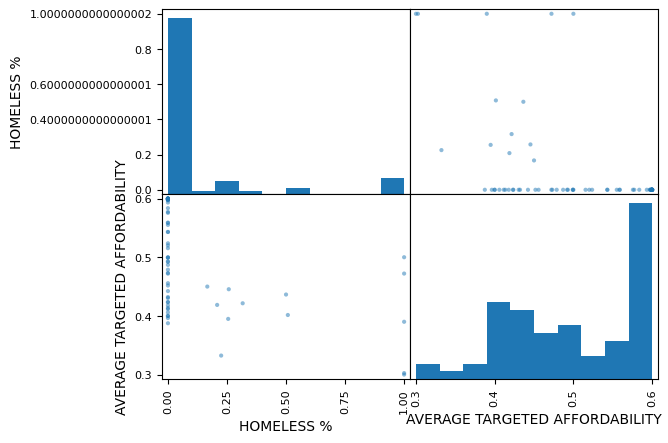

In [31]:
x_plot2 = X_train[["HOMELESS %", "AVERAGE TARGETED AFFORDABILITY"]]
pd.plotting.scatter_matrix(x_plot2)

array([[<Axes: xlabel='CDLAC TOTAL POINTS SCORE', ylabel='CDLAC TOTAL POINTS SCORE'>,
        <Axes: xlabel='CDLAC TIE-BREAKER SELF SCORE', ylabel='CDLAC TOTAL POINTS SCORE'>],
       [<Axes: xlabel='CDLAC TOTAL POINTS SCORE', ylabel='CDLAC TIE-BREAKER SELF SCORE'>,
        <Axes: xlabel='CDLAC TIE-BREAKER SELF SCORE', ylabel='CDLAC TIE-BREAKER SELF SCORE'>]],
      dtype=object)

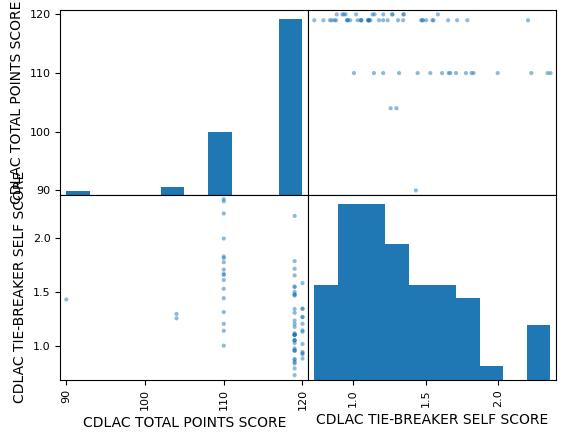

In [32]:
x_plot3 = X_train[['CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE']]
pd.plotting.scatter_matrix(x_plot3)

### Data Transform

In [33]:
# get data from preprocessed files
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()
numeric = ["AVERAGE TARGETED AFFORDABILITY", 'CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE', "BOND REQUEST", "HOMELESS %"]
cat = ["CONSTRUCTION TYPE", "HOUSING TYPE", "CDLAC POOL", "NEW CONSTRUCTION SET ASIDE", "CDLAC REGION"]

In [34]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

# Define the binary transformation function
def binary_homeless(X):
    return (X > 0).astype(int)

# Create the FunctionTransformer with feature_names_out
homeless_transformer = FunctionTransformer(
    func=binary_homeless,
    feature_names_out='one-to-one'
)

# Define the ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('homeless_binary', homeless_transformer, ['HOMELESS %'])
    ],
    remainder='passthrough',
)

# Fit and transform X_train
X_train_transformed = column_transformer.fit_transform(X_train)

# Get output column names
output_columns = column_transformer.get_feature_names_out()

# Convert to DataFrame with proper column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=output_columns)

# Verify the output
print(X_train_transformed_df[['homeless_binary__HOMELESS %']].head())
print("Output columns:", X_train_transformed_df.columns.tolist())

# Optional: Apply to X_test
X_test_transformed = column_transformer.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=output_columns)

  homeless_binary__HOMELESS %
0                           0
1                           0
2                           1
3                           1
4                           0
Output columns: ['homeless_binary__HOMELESS %', 'remainder__AVERAGE TARGETED AFFORDABILITY', 'remainder__CDLAC TOTAL POINTS SCORE', 'remainder__CDLAC TIE-BREAKER SELF SCORE', 'remainder__BOND REQUEST', 'remainder__CONSTRUCTION TYPE', 'remainder__HOUSING TYPE', 'remainder__CDLAC POOL', 'remainder__NEW CONSTRUCTION SET ASIDE', 'remainder__CDLAC REGION']


In [35]:
print(x_train_scaleddf[numeric].skew())

NameError: name 'x_train_scaleddf' is not defined

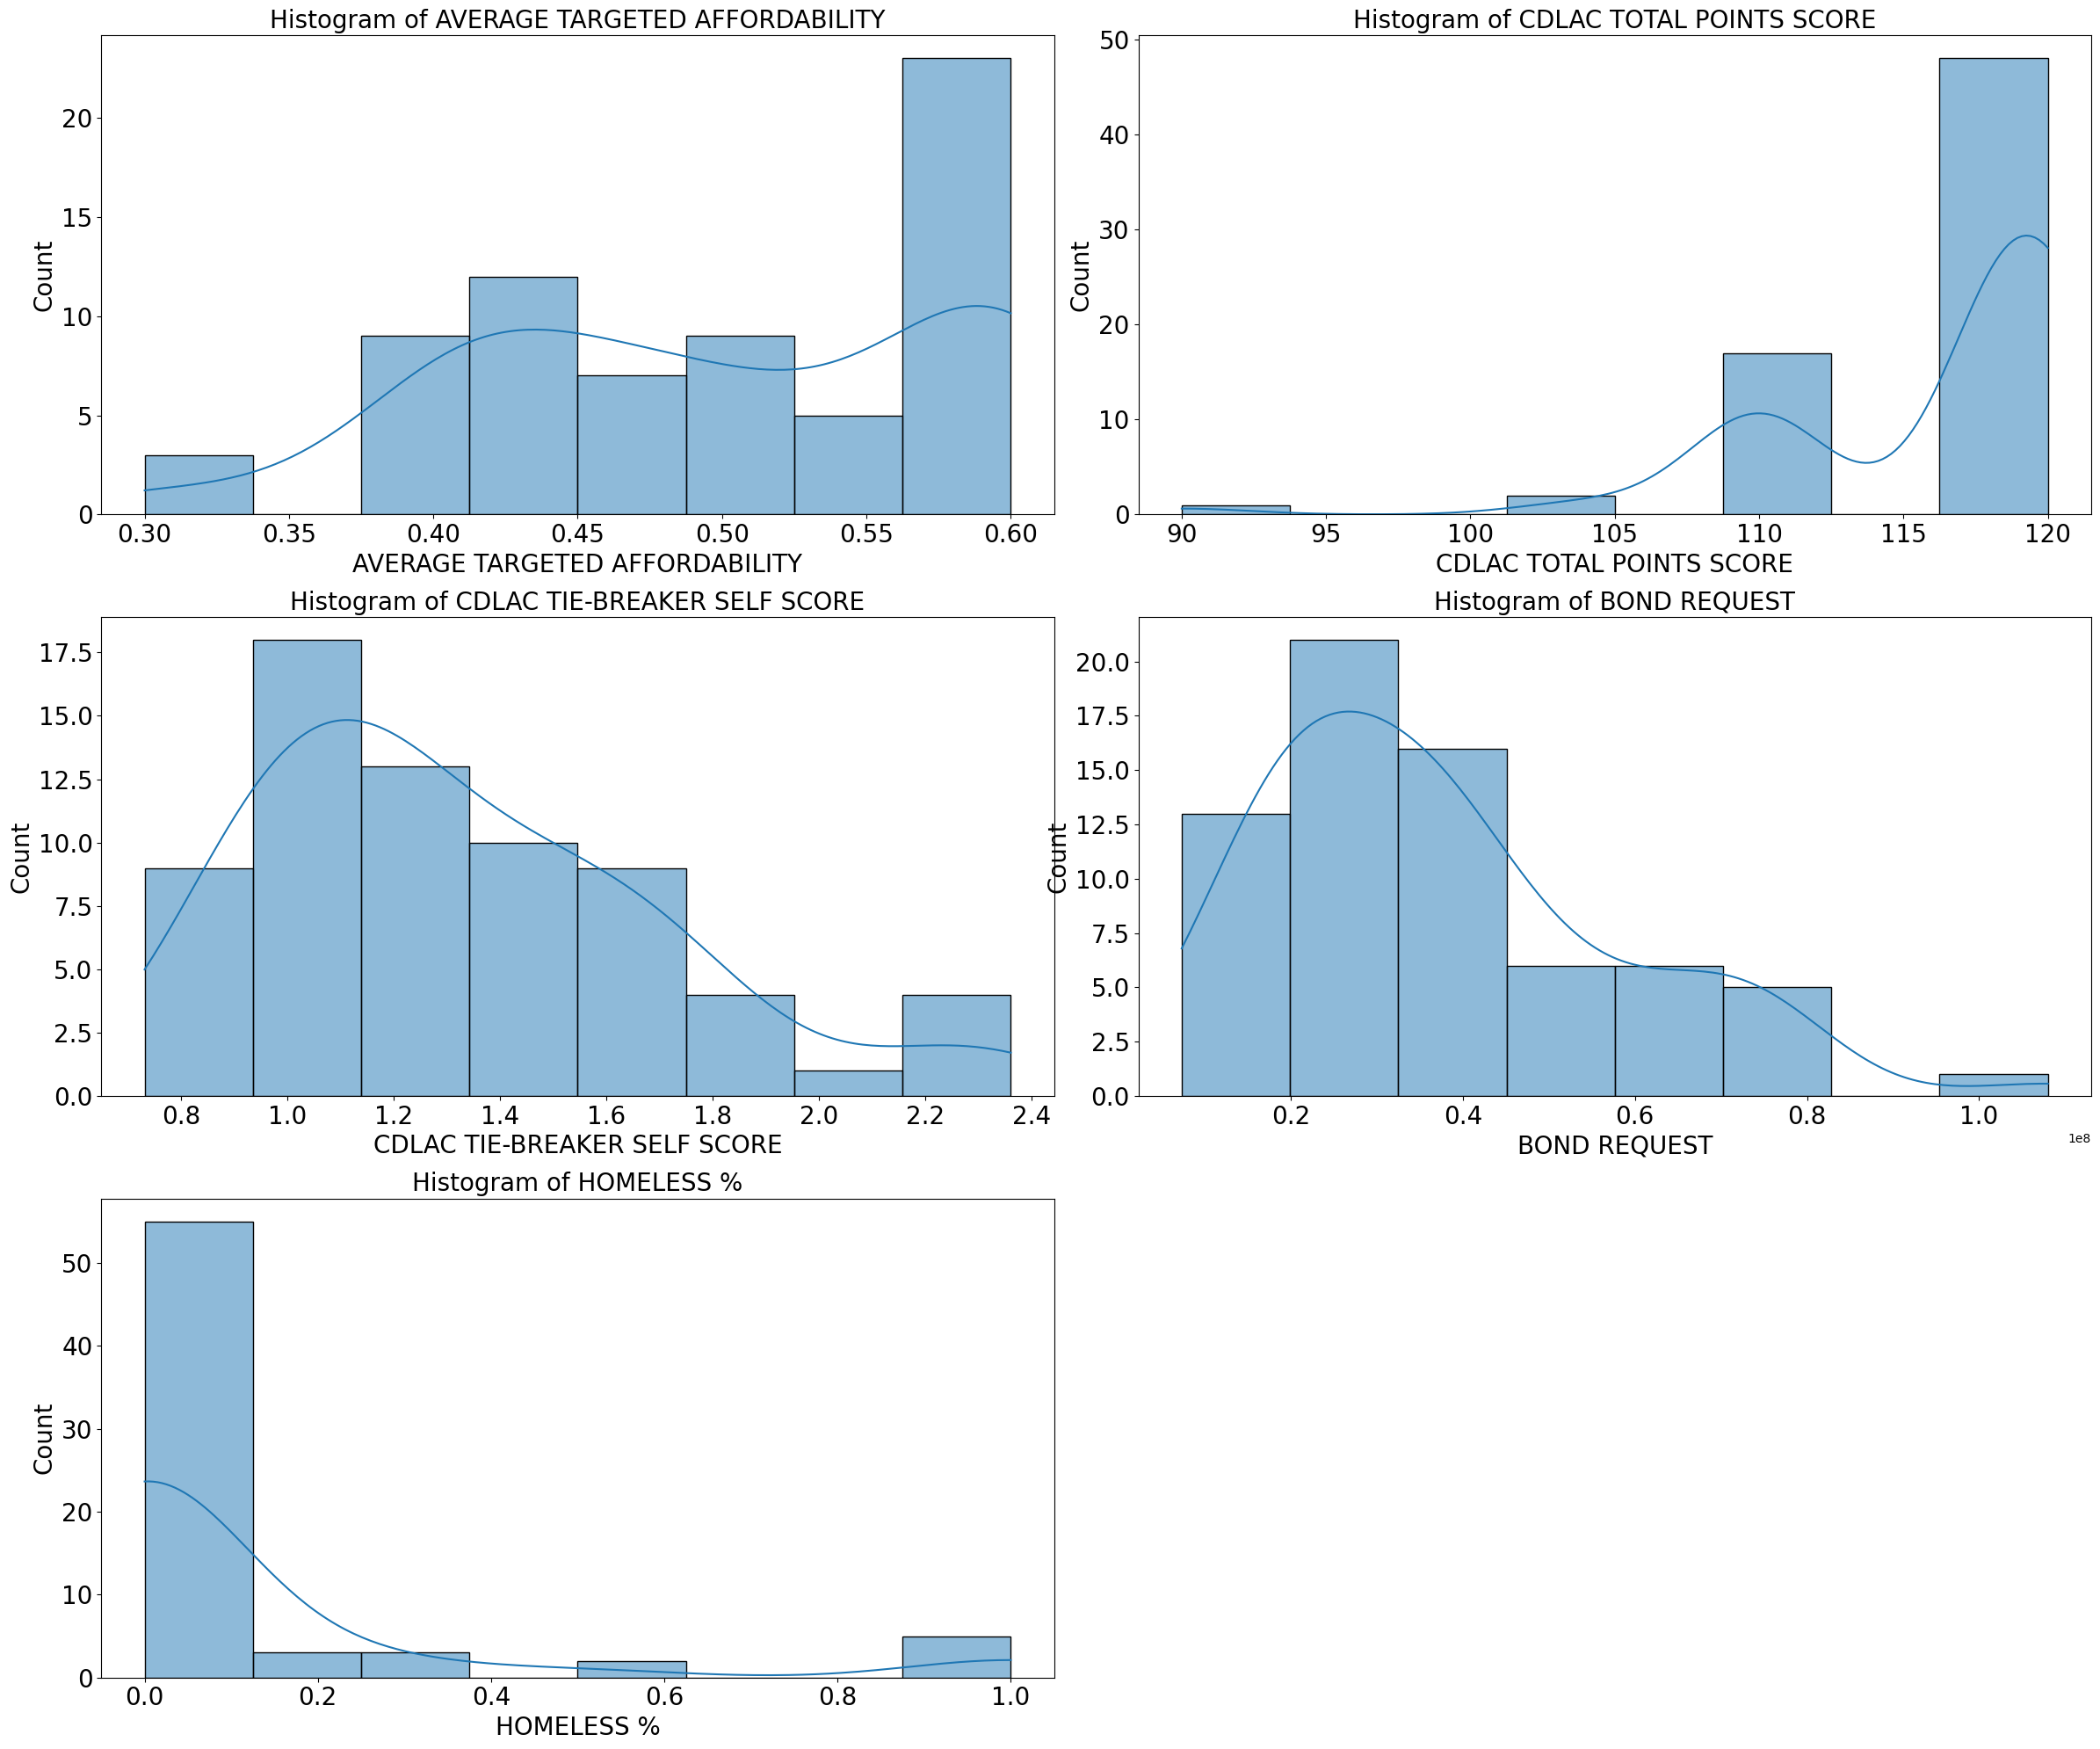

In [36]:
# Create a 2x3 subplot grid
f, axes = plt.subplots(3, 2, figsize=(24, 20))

# Flatten axes for easier iteration (axes is a 2D array)
axes = axes.flatten()

# Plot a histogram for each numeric feature
for i, feature in enumerate(numeric):
    sb.histplot(data=X_train, x=feature, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {feature}', fontsize=20)
    axes[i].set_xlabel(feature, fontsize=20)
    axes[i].set_ylabel('Count', fontsize=20)
    axes[i].tick_params(axis='both', labelsize=20)

# Turn off the unused subplot (6th plot, index 5)
axes[5].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [150]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

In [97]:
X_train['HOMELESS %'] = log_transformer.transform(X_train['HOMELESS %'])

In [98]:
X_train.head()

,AVERAGE TARGETED AFFORDABILITY,CDLAC TOTAL POINTS SCORE,CDLAC TIE-BREAKER SELF SCORE,BOND REQUEST,HOMELESS %,CONSTRUCTION TYPE,HOUSING TYPE,CDLAC POOL,NEW CONSTRUCTION SET ASIDE,CDLAC REGION
0,0.596957,119,1.502724,50500000.0,0.000000,New Construction,Non-Targeted,New Construction,none,"Bay Area (Alameda, Contra Costa, Marin, San Fr..."
1,0.500000,90,1.432348,16212891.0,0.000000,Acq and Rehabilitation,Non-Targeted,Other Rehabilitation,none,"Coastal (Monterey, Napa, Orange, San Benito, S..."
2,0.394898,119,1.109558,53314000.0,0.227217,New Construction,Non-Targeted,New Construction,"Homeless, ELI/VLI","Bay Area (Alameda, Contra Costa, Marin, San Fr..."
3,0.421519,119,0.881833,38217137.0,0.274943,New Construction,Seniors,New Construction,"Homeless, ELI/VLI","Bay Area (Alameda, Contra Costa, Marin, San Fr..."
4,0.599257,119,1.477445,68750000.0,0.000000,New Construction,Large Family,New Construction,none,"Bay Area (Alameda, Contra Costa, Marin, San Fr..."


<Axes: xlabel='HOMELESS %', ylabel='Count'>

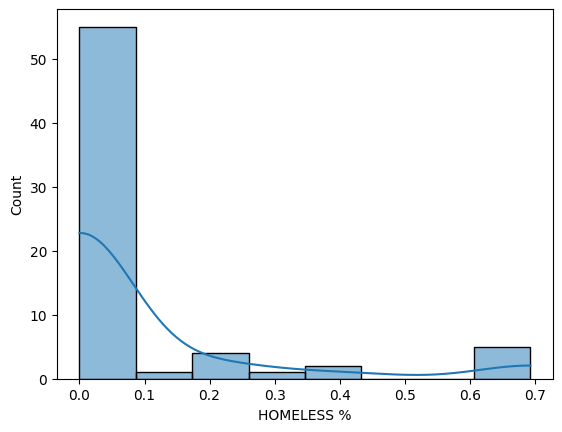

In [102]:
sb.histplot(data=X_train['HOMELESS %'], kde=True)

Not much of a change in distribution even after adding log, try binning

In [138]:
from sklearn.preprocessing import KBinsDiscretizer
binning = KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy= 'quantile')

In [139]:
# Fit the binning transformer on the 'HOMELESS %' column
X_train_binned = binning.fit_transform(X_train[['HOMELESS %']])  # Use DataFrame, not Series

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [140]:
print(binning.bin_edges_[0])

[0. 1.]


Binning doesn't really work coz most values are 0. Probably just change it to a binary feature 

In [145]:
# Create binary feature: 1 if HOMELESS % > 0, 0 otherwise
X_train['HOMELESS_present'] = (X_train['HOMELESS %'] > 0).astype(int)

# Verify the new column
print(X_train['HOMELESS_present'].value_counts())
print(X_train[['HOMELESS %', 'HOMELESS_present']].head())

HOMELESS_present
0    55
1    13
Name: count, dtype: int64
   HOMELESS %  HOMELESS_present
0    0.000000                 0
1    0.000000                 0
2    0.255102                 1
3    0.316456                 1
4    0.000000                 0


In [149]:
numeric.remove("HOMELESS %")
cat.append("HOMELESS_present")

ValueError: list.remove(x): x not in list

In [158]:
X_train['CDLAC TOTAL POINTS SCORE'].describe()

count     68.000000
mean     116.073529
std        5.596684
min       90.000000
25%      110.000000
50%      119.000000
75%      119.000000
max      120.000000
Name: CDLAC TOTAL POINTS SCORE, dtype: float64

In [165]:
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')
X_train['CDLAC_transformed'] = transformer.fit_transform(X_train[['CDLAC TOTAL POINTS SCORE']])

In [163]:
X_train['CDLAC_sqrt'] = np.sqrt(X_train['CDLAC TOTAL POINTS SCORE'] - 90)

<Axes: xlabel='CDLAC_transformed', ylabel='Count'>

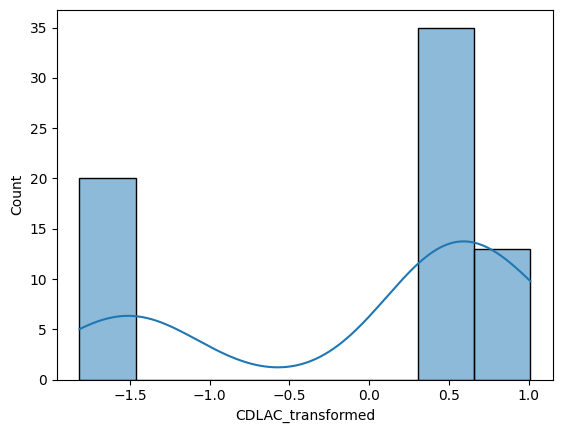

In [166]:
sb.histplot(data=X_train['CDLAC_transformed'], kde=True)

In [9]:
x_train_encoded = encode.fit_transform(X_train[cat])
x_train_encoded.shape

(68, 21)

In [10]:
dense_x_train = x_train_encoded.toarray()
print(dense_x_train[:5])  # Displays the first 5 rows

[[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]


In [11]:
encode.categories_

[array(['Acq and Rehabilitation', 'Adaptive Reuse', 'New Construction'],
       dtype=object),
 array(['At-Risk', 'Large Family', 'Non-Targeted', 'Seniors',
        'Special Needs'], dtype=object),
 array(['New Construction', 'Other Rehabilitation', 'Preservation',
        'Rural'], dtype=object),
 array(['ELI/VLI', 'Homeless, ELI/VLI', 'none'], dtype=object),
 array(['Balance of Los Angeles County',
        'Bay Area (Alameda, Contra Costa, Marin, San Francisco, San Mateo, Santa Clara, and Santa Cruz Counties)',
        'City of Los Angeles',
        'Coastal (Monterey, Napa, Orange, San Benito, San Diego, San Luis Obispo, Santa Barbara, Sonoma, and Ventura Counties) ',
        'Inland (Fresno, Imperial, Kern, Kings, Madera, Merced, Riverside, San Bernardino, Stanislaus, and Tulare Counties)',
        'Northern (Butte, El Dorado, Placer, Sacramento, San Joaquin, Shasta, Solano, Sutter, Yuba, and Yolo Counties)'],
       dtype=object)]

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

numeric = ["AVERAGE TARGETED AFFORDABILITY", 'CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE', "BOND REQUEST", "HOMELESS %"]
cat = ["CONSTRUCTION TYPE", "HOUSING TYPE", "CDLAC POOL", "NEW CONSTRUCTION SET ASIDE", "CDLAC REGION"]

# numeric pipeline
num_pipe = make_pipeline(MinMaxScaler())

# categorical pipeline
cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numeric),
        ('cat', cat_pipe, cat)
    ])

# Model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)
# pipelines
def binary_homeless(X):
    return (X > 0).astype(int)

homeless_transformer = FunctionTransformer(
    func=binary_homeless,
    feature_names_out="one-to-one",
)
homeless_pipe = make_pipeline(homeless_transformer)

points_transformer = PowerTransformer(method="yeo-johnson")
points_pipe = make_pipeline(points_transformer, MinMaxScaler())

cat_pipe = make_pipeline(OneHotEncoder())
remainder_num_pipe = make_pipeline(StandardScaler())

preprocessor_pipe = ColumnTransformer(
    transformers=[
        ("homeless_binary", homeless_pipe, ["HOMELESS %"]),
        ("points_power", points_pipe, ["CDLAC TOTAL POINTS SCORE"]),
        ("category", cat_pipe, cat),
    ],
    remainder=remainder_num_pipe,
)
# transform
x_train_prepared = preprocessor_pipe.fit_transform(X_train)


In [39]:
x_train_prepared.shape

(68, 26)

In [40]:
preprocessor_pipe.get_feature_names_out()

array(['homeless_binary__HOMELESS %',
       'points_power__CDLAC TOTAL POINTS SCORE',
       'category__CONSTRUCTION TYPE_Acq and Rehabilitation',
       'category__CONSTRUCTION TYPE_Adaptive Reuse',
       'category__CONSTRUCTION TYPE_New Construction',
       'category__HOUSING TYPE_At-Risk',
       'category__HOUSING TYPE_Large Family',
       'category__HOUSING TYPE_Non-Targeted',
       'category__HOUSING TYPE_Seniors',
       'category__HOUSING TYPE_Special Needs',
       'category__CDLAC POOL_New Construction',
       'category__CDLAC POOL_Other Rehabilitation',
       'category__CDLAC POOL_Preservation', 'category__CDLAC POOL_Rural',
       'category__NEW CONSTRUCTION SET ASIDE_ELI/VLI',
       'category__NEW CONSTRUCTION SET ASIDE_Homeless, ELI/VLI',
       'category__NEW CONSTRUCTION SET ASIDE_none',
       'category__CDLAC REGION_Balance of Los Angeles County',
       'category__CDLAC REGION_Bay Area (Alameda, Contra Costa, Marin, San Francisco, San Mateo, Santa Clara, and 

In [41]:
x_train_prepared_df = pd.DataFrame(x_train_prepared, columns = preprocessor_pipe.get_feature_names_out())

In [42]:
selector = make_column_selector(pattern = r'^(remainder_|points_)')
selected_columns = selector(x_train_prepared_df)

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1597: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


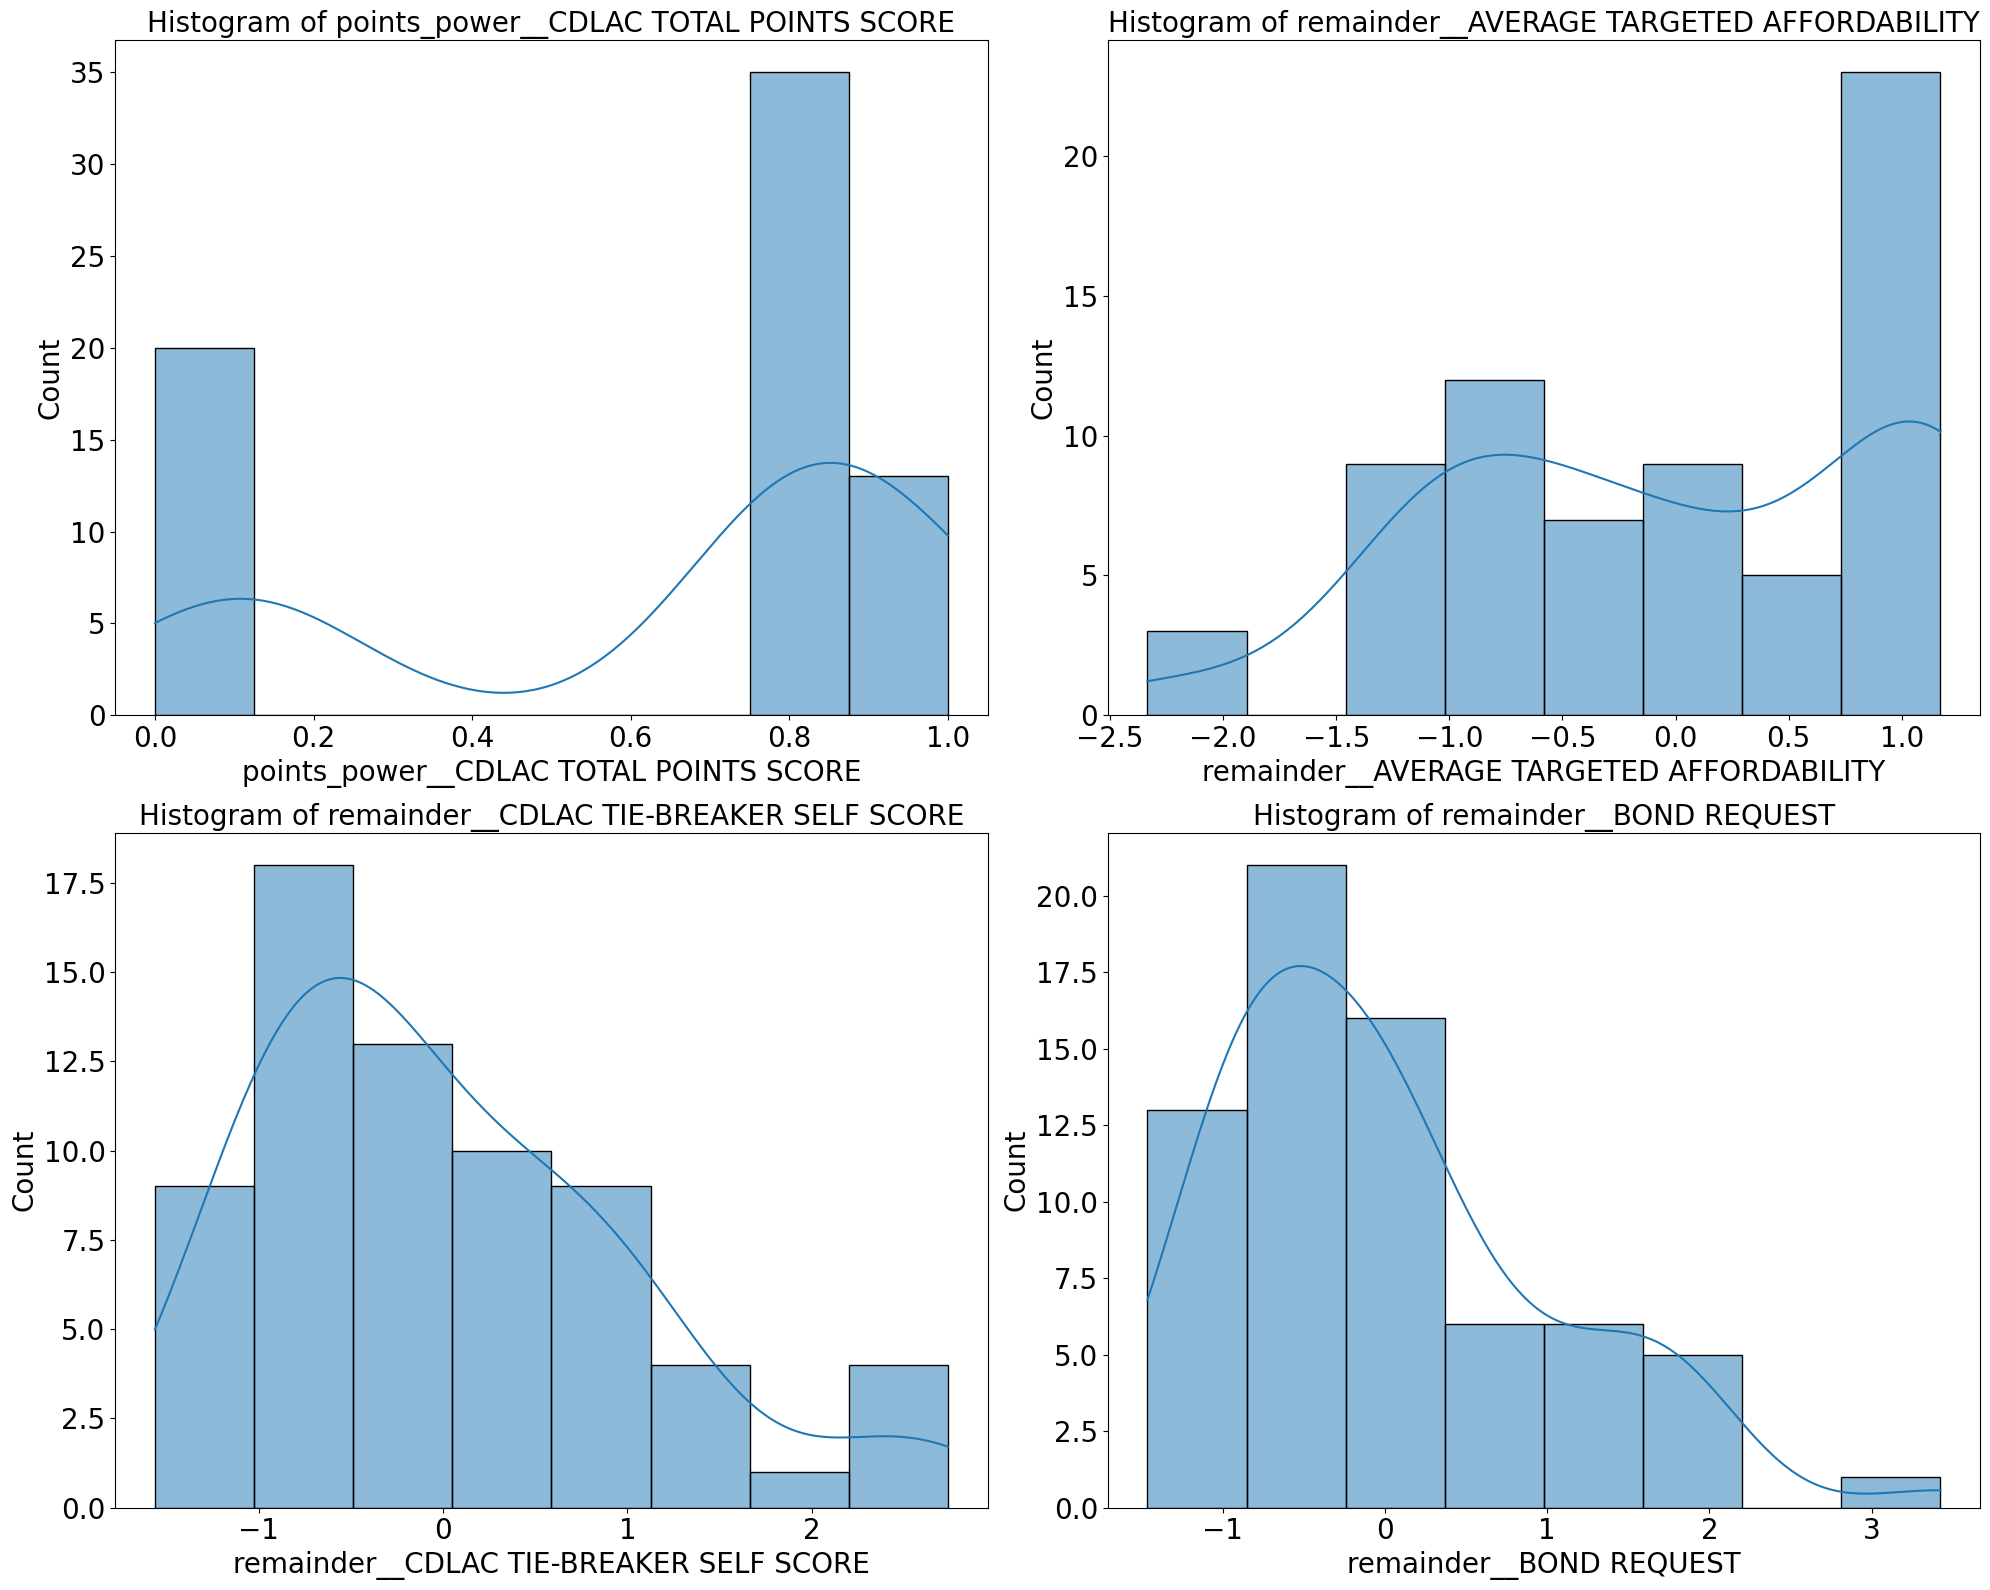

In [44]:
from sklearn.compose import make_column_selector
# Create a 2x3 subplot grid
f, axes = plt.subplots(2, 2, figsize=(20, 16))

# Flatten axes for easier iteration (axes is a 2D array)
axes = axes.flatten()

# Plot a histogram for each numeric feature
for i, feature in enumerate(selected_columns):
    sb.histplot(data=x_train_prepared_df[selected_columns], x=feature, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {feature}', fontsize=20)
    axes[i].set_xlabel(feature, fontsize=20)
    axes[i].set_ylabel('Count', fontsize=20)
    axes[i].tick_params(axis='both', labelsize=20)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Model training
- RandomForestClassifier??
- metric F1 Score and ROC-AUC??

In [68]:
X_train_prepared = preprocessor.fit_transform(X_train)

In [69]:
X_train_prepared.shape

(68, 26)

In [70]:
X_train_prepared[:5]

array([[0.98985507, 0.96666667, 0.47324698, 0.42885523, 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.43003639, 0.088283  , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.31632653, 0.96666667, 0.23184425, 0.45680656, 0.25510204,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
      

In [71]:
# Train model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['AVERAGE TARGETED '
                                                   'AFFORDABILITY',
                                                   'CDLAC TOTAL POINTS SCORE',
                                                   'CDLAC TIE-BREAKER SELF '
                                                   'SCORE',
                                                   'BOND REQUEST',
                                                   'HOMELESS %']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CONSTRUCTION TYPE',
                                                   'HOUSING TYPE', 'CDLAC POOL',
                                                   'NEW CONSTRUCTION SET ASIDE',
                                                   'CDLAC REGION'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [72]:
from sklearn.metrics import roc_auc_score
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

ROC-AUC: 0.812


In [73]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {scores.mean():.3f} ± {scores.std():.3f}")

Cross-validation F1 scores: 0.468 ± 0.223


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.67      0.60      0.63        10

    accuracy                           0.70        23
   macro avg       0.69      0.68      0.69        23
weighted avg       0.69      0.70      0.69        23



## Testing different models